# Enter data here

In [7]:
# Enter your information below. For each line, enter your info between the double quotes

# How long have you resided in Texas (in years)?
YEARS_OF_RESIDENCE = ""

# How old is your vehicle (in years)?
VEHICLE_AGE = ""

# If you are not using kmz routes OR you want to add counties not intersected by your kmz routes, list them below
# Add the county names between the double quotes, each separated by a comma, and with the first letter capitalized
# ex) "Brazos, Burleson, Harris"
USER_COUNTIES = "Brazos, Burleson, Harris, hello"

In [83]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from itertools import combinations
from shapely.geometry import LineString
import fiona
fiona.supported_drivers["LIBKML"] = "raw"


In [9]:
USER_COUNTIES.replace(", ", ",").split(",")

['Brazos', 'Burleson', 'Harris', 'hello']

In [10]:
# Process user input

# Print user input
print(f"Years of Texas residence: {YEARS_OF_RESIDENCE}")
print(f"Age of vehicle: {YEARS_OF_RESIDENCE}")

county_list = USER_COUNTIES.replace(", ", ",").split(",")
print(f"Listed counties: {county_list}")

# Check for kmz files
kmz_dir = Path("data/kmz")
kmz_files = []

if kmz_dir.is_dir():
    kmz_files = list(kmz_dir.glob("*.kmz"))

if kmz_files:
    print("KMZ files found")
    [print(f" - {kmz.name}") for kmz in kmz_dir.iterdir()]
else:
    print("No kmz files provided or they are in the wrong folder.")

Years of Texas residence: 
Age of vehicle: 
Listed counties: ['Brazos', 'Burleson', 'Harris', 'hello']
No kmz files provided or they are in the wrong folder.


In [11]:
list(kmz_dir.glob("*.kmz"))

[]

# Check spelling of county names

In [12]:
# Open counties and prep TX boundary for later
counties = gpd.read_file("data/Texas_County_Boundaries.geojson")
tx_boundary = counties.dissolve()

# Get UTM crs for Texas for calcualtions later
tx_utm = tx_boundary.estimate_utm_crs()

In [13]:
# Check if names aren't in the county shapefile
bad_names = [name for name in county_list if name not in counties["CNTY_NM"].values]

if bad_names:
    print("The following county names could not be found in the county shapefile from TXDOT:")
    [print(f" - {name}") for name in bad_names]
    print("\n")
    print("Check the spelling and capitalization of the names above. Once changes are made to USER_COUNTIES, rerun the notebook.")
    print("The official county names are listed below:")
    [print(f" - {name}") for name in counties["CNTY_NM"].sort_values().values]

The following county names could not be found in the county shapefile from TXDOT:
 - hello


Check the spelling and capitalization of the names above. Once changes are made to USER_COUNTIES, rerun the notebook.
The official county names are listed below:
 - Anderson
 - Andrews
 - Angelina
 - Aransas
 - Archer
 - Armstrong
 - Atascosa
 - Austin
 - Bailey
 - Bandera
 - Bastrop
 - Baylor
 - Bee
 - Bell
 - Bexar
 - Blanco
 - Borden
 - Bosque
 - Bowie
 - Brazoria
 - Brazos
 - Brewster
 - Briscoe
 - Brooks
 - Brown
 - Burleson
 - Burnet
 - Caldwell
 - Calhoun
 - Callahan
 - Cameron
 - Camp
 - Carson
 - Cass
 - Castro
 - Chambers
 - Cherokee
 - Childress
 - Clay
 - Cochran
 - Coke
 - Coleman
 - Collin
 - Collingsworth
 - Colorado
 - Comal
 - Comanche
 - Concho
 - Cooke
 - Coryell
 - Cottle
 - Crane
 - Crockett
 - Crosby
 - Culberson
 - Dallam
 - Dallas
 - Dawson
 - De Witt
 - Deaf Smith
 - Delta
 - Denton
 - Dickens
 - Dimmit
 - Donley
 - Duval
 - Eastland
 - Ector
 - Edwards
 - El Paso
 - El

## Open kmz routes and get intersecting counties

In [14]:
if kmz_files:
    # Open kmz routes
    kmz = [gpd.read_file(f) for f in kmz_files]
    routes = pd.concat(kmz, ignore_index=True)
    
    # Filter out the point data
    routes = routes[routes.geometry.type == "LineString"]

    # Clip to TX boundary
    clipped_routes = routes.clip(tx_boundary)

    # Get names of intersecting counties and append to county list
    itx_county_names = list(clipped_routes.overlay(counties)["CNTY_NM"])
    [county_list.append(name) for name in itx_county_names if name not in county_list]
    county_list = sorted(county_list)

    

## Visited Counties

In [15]:
visited_counties = counties[counties["CNTY_NM"].isin(county_list)]
visited_counties.explore()


## Get list of counties

# Begin processing

## Reference

OG List:
- ~~most counties visited per year of TX residence~~
- ~~greatest distance between counties visited~~
- \# of state parks, natural areas, etc. visited

Andrew's List
1. Highest and/or lowest elevation visited
2. Squarest county visited (need a good map/metric for this)
3. Most remote: County least visited by GEOG people, ties are settled by lowest reported population of the county
4. Longest contiguous boundary drawn by counties visited AND/OR largest contiguous area by counties visited
5. Highest/lowest gas price (measured in dollars/gallon, not tank total) paid for. Requires picture of receipt 
6. Most Buc-ees visited 
7. The (b)oldest mile: Greatest number of miles driven*age of vehicle in years
8. Alphabet Bingo: Most counties visited with unique first letters.(eg. B for Brazos, G for Grimes, R for Robertson, but visiting Burleson won't help you cause you already have Brazos for B), ties are settled by the longest Scrabble-official word the participants can make from their letters 
9. Map contest: the only rule/prompt is that the map needs to visualize your Texas travels. Winner is chosen by popular vote among GEOG people

In [16]:
def counties_per_yr_tx_res(counities, num_years:int) -> float:
    """
    Divide the number of counties by the number of years.
    counties can be any kind of iterable
    num_years is an int
    """
    return round(len(counties)/num_years, 2)

In [88]:
def greatest_distance_between_counties(counties):
    """
    Measures the distance between county centroids.
    Returns the greatest distance. 
    """

    # Project the gdf for distance calculations
    vc_proj = visited_counties.to_crs(tx_utm)

    # Calculate the centroid of every county
    vc_proj["centroid"] = vc_proj.centroid

    # Create LineStrings of every combination of centroid
    coord_combos = combinations(vc_proj["centroid"].values, 2)
    linestrings = [LineString(combo) for combo in coord_combos]

    # Return the longest LineString
    longest_linestring = sorted(linestrings, key=lambda x: x.length)[-1]

    return longest_linestring

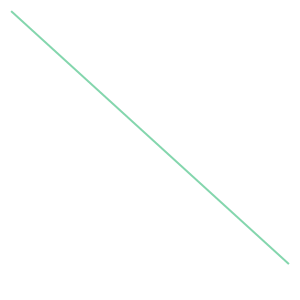

In [89]:
greatest_distance_between_counties(visited_counties)

In [29]:
def alphabet_bingo(counties):
    '''Loops through county names, slices the first letter of each county
    Returns a set of unique county first letters'''
    countylist = []
    for i in counties['CNTY_NM']:
        countylist.append(i[0])
    countyset = set(countylist)
    return countyset

In [32]:
countyset = alphabet_bingo(visited_counties)
countyset

{'B', 'H'}